In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import torchvision
from torchvision import models, transforms
from tqdm.notebook import tqdm
import torch.nn.functional as F
import albumentations as A

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
def textfile_to_dataframe(path, filename, dataset):
      with open(data_path + filename) as f:
        data_lines = f.readlines()
  
      data = []
      for line in data_lines:
        line_list = line.split(maxsplit=1)
        img_num = line_list[0] + '.jpg'
        label = line_list[1]
        label = label.strip('\n')
        image_path = 'gdrive/MyDrive/top_gun_dl/repo/data/images/cropped/' + img_num
        row = [img_num, dataset, label, image_path]
        data.append(row)

    df = pd.DataFrame(data, columns=['image', 'dataset', 'label', 'path'])
    return df

In [4]:
data_path = 'gdrive/MyDrive/top_gun_dl/repo/data/'

In [5]:
train_df = textfile_to_dataframe(data_path, 'images_family_trainval.txt', 'train')
valid_df = textfile_to_dataframe(data_path, 'images_family_test.txt', 'validation')

In [6]:
train_df.head(2).path.iloc[0]

'gdrive/MyDrive/top_gun_dl/repo/data/images/cropped/1025794.jpg'

## View an Image

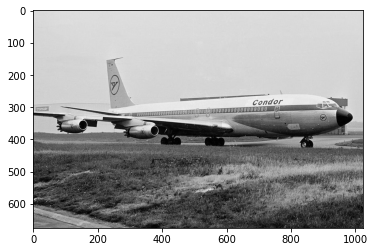

In [ ]:
pic = cv2.imread('gdrive/MyDrive/top_gun_dl/repo/data/images/cropped/1025794.jpg')

plt.imshow(pic)

## Create a Dataset

In [7]:
class AirplaneDataset(Dataset):
    def __init__(self, df, class_dict, resize_image=True, augment=False):
        self.df = df
        # label dictionary
        classes = self.df.label.unique()
        self.label_dict = {k: v for v, k in enumerate(classes)}
        self.augment = augment
        self.resize_image = resize_image
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        path_file = row['path']
        
        # read img
        img = cv2.imread(path_file)
        
        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.resize_image:
            try:
                img = cv2.resize(img, (256,256))
            except:
                print(path)
        
        # move color channels to correct spot
        img = np.transpose(img, (2, 0, 1))
        
        if self.augment == True:
            transform = A.Compose([
                # spatial transforms
                A.HorizontalFlip(p=.5),
                A.VerticalFlip(p=.5),
                A.Rotate(limit = 10, 
                         border_mode = cv2.BORDER_CONSTANT, p = .75),
                
                # pixel-level transformation
                A.RandomBrightnessContrast(p=0.5)])
            img = transform(image=img)['image']
            
        # convert to [0,1] scale
        img = torch.tensor(img / 255.).float()
        # access the label dictionary
        label = torch.tensor(self.label_dict[row['label']])

        return img, label
        

In [8]:
train_df.head()

,image,dataset,label,path
0,1025794.jpg,train,Boeing 707,gdrive/MyDrive/top_gun_dl/repo/data/images/cro...
1,1340192.jpg,train,Boeing 707,gdrive/MyDrive/top_gun_dl/repo/data/images/cro...
2,0056978.jpg,train,Boeing 707,gdrive/MyDrive/top_gun_dl/repo/data/images/cro...
3,0698580.jpg,train,Boeing 707,gdrive/MyDrive/top_gun_dl/repo/data/images/cro...
4,0450014.jpg,train,Boeing 707,gdrive/MyDrive/top_gun_dl/repo/data/images/cro...


In [9]:
# First we need to label encode the classes
classes = sorted(train_df.label.unique())

# Creating the label dictionary for all classes ... interesting that I only see 70 here!?
class_dict = {c:i for i,c in enumerate(classes)} # class to ID

In [10]:
# Creating DataSets
train_ds = AirplaneDataset(train_df, class_dict, resize_image=True, augment=True)
valid_ds = AirplaneDataset(valid_df, class_dict, resize_image=True)

# Sending to DataLoaders
BatchSize = 32
train_dl = DataLoader(train_ds, batch_size=BatchSize, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=8, shuffle=False)

## Create the model

In [11]:
class CNN(nn.Module):
    def __init__(self, class_dict):
        super().__init__()
        
        # convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)

        # linear layers
        self.linear1 = nn.Linear(16384, 1000)
        self.linear2 = nn.Linear(1000, len(class_dict.values()))
        
        # pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # activation
        self.relu = nn.ReLU()
        
        # for unrolling into FC layer
        self.unroll = nn.Flatten()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool(x)

        # unroll x for FC layer
        x = self.linear1(self.unroll(x))
        x = self.relu(x)
        x = self.linear2(x)
        
        return x

In [12]:
def topk_accuracy(y, y_hat, correct_list, incorrect_list):
    length = len(y)
    correct = 0
    onepass_correct = []
    onepass_incorrect = []
    for i in range(length):
        if y[i] in y_hat[i]:
            # add the index, label and prediction to a list
            onepass_correct.append((i, y[i], y_hat[i]))
            correct += 1
        else:
        # add the index, label and prediction to a list
            onepass_incorrect.append((i, y[i], y_hat[i]))

      # add the list to the full list
        correct_list.append(onepass_correct)
        incorrect_list.append(onepass_incorrect)

    return round(correct / length, 3), correct_list, incorrect_list

In [13]:
def one_pass(model, dataloader, optimizer, loss_function, correct_list, incorrect_list, train=False):
    losses = []
    actual = []
    topk_list = []
    predictions = []
    
    for x, y in tqdm(dataloader):
        x, y = x.to(device), y.to(device)
        if not train:
            model.eval()
        else:
            model.train()
            
        model.train()
        y_hat = model(x)
        argmax = torch.argmax(y_hat, dim=1)
        loss = loss_function(y_hat, y)

        # get the top k
        topk = torch.topk(y_hat, k=5, dim=1, largest=True)

        # detach
        label_actual = y.cpu().detach().numpy()
        label_pred = argmax.cpu().detach().numpy()

        # add to the lists
        actual.extend(label_actual)
        predictions.extend(label_pred)
        topk_list.extend(topk.indices.cpu().detach().numpy())    # pass the indices to the list

        # if train is true, backprop.
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        losses.append(loss.item())
  
    # calculate accuracy
    topk_acc, correct_list, incorrect_list = topk_accuracy(actual, topk_list, correct_list, incorrect_list)
    accuracy = round(accuracy_score(actual, predictions), 3)
    average_loss = np.mean(losses)
    return average_loss, accuracy, topk_acc, correct_list, incorrect_list

## Train Model

In [14]:
def train_model(model, train_dl, test_df, epochs=5, lr=0.01, optimizer=None):
    correct_list_train = []
    incorrect_list_train = []
    correct_list_val = []
    incorrect_list_val = []

    if optimizer:
        optimizer = optimizer
    else:
        optimizer = optim.Adam(model.parameters(), lr = lr)
    loss_function = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        train_loss, train_acc, train_k, correct_list_train, incorrect_list_train = one_pass(model, 
                                                                                            train_dl, 
                                                                                            optimizer, 
                                                                                            loss_function, 
                                                                                            correct_list_train, 
                                                                                            incorrect_list_train, 
                                                                                            train=True)
        
        val_loss, val_acc, val_k, correct_list_val, incorrect_list_val = one_pass(model, 
                                                                                  test_df, 
                                                                                  optimizer, 
                                                                                  loss_function, 
                                                                                  correct_list_val, 
                                                                                  incorrect_list_val, 
                                                                                  train=False)
        
        print('Training Loss:', round(train_loss, 3))
        print(f"Epoch Number: {epoch+1}. Training Top 5 Accuracy: {train_k} Test Top 5 Accuracy: {val_k}")
    
    return correct_list_train, incorrect_list_train, correct_list_val, incorrect_list_val

In [15]:
# convert to gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
model = CNN(class_dict)
model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=16384, out_features=1000, bias=True)
  (linear2): Linear(in_features=1000, out_features=70, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (unroll): Flatten(start_dim=1, end_dim=-1)
)

In [17]:
correct_train, incorrect_train, correct_val, incorrect_val = train_model(model, train_dl, valid_dl, epochs=8)

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

Training Loss: 5.652
Epoch Number: 1. Training Top 5 Accuracy: 0.219 Test Top 5 Accuracy: 0.22


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

Training Loss: 4.089
Epoch Number: 2. Training Top 5 Accuracy: 0.226 Test Top 5 Accuracy: 0.23


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

Training Loss: 4.084
Epoch Number: 3. Training Top 5 Accuracy: 0.228 Test Top 5 Accuracy: 0.23


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

Training Loss: 4.082
Epoch Number: 4. Training Top 5 Accuracy: 0.231 Test Top 5 Accuracy: 0.23


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

Training Loss: 4.081
Epoch Number: 5. Training Top 5 Accuracy: 0.228 Test Top 5 Accuracy: 0.23


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

Training Loss: 4.079
Epoch Number: 6. Training Top 5 Accuracy: 0.228 Test Top 5 Accuracy: 0.23


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

Training Loss: 4.079
Epoch Number: 7. Training Top 5 Accuracy: 0.231 Test Top 5 Accuracy: 0.23


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

Training Loss: 4.079
Epoch Number: 8. Training Top 5 Accuracy: 0.229 Test Top 5 Accuracy: 0.23


## Accuracy Plots
- Plotting the models top 5 accuracy from the CNN and the VGG models.

In [18]:
# these are the top 5 accuracy scores between the 2 models
vgg_train = [0.248, 0.285, 0.324, 0.326, 0.343, 0.354, 0.36, 0.361]
vgg_test = [0.324, 0.359, 0.39, 0.383, 0.398, 0.435, 0.419, 0.423]

cnn_train = [0.219, 0.226, 0.228, 0.231, 0.228, 0.228, 0.231, 0.229]
cnn_test = [0.22, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23]

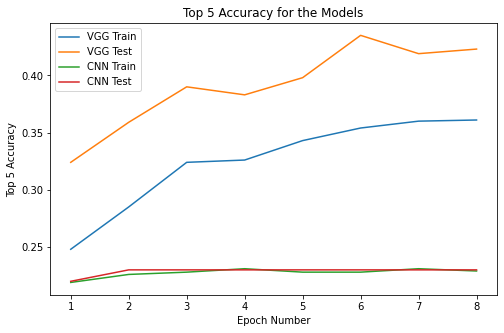

In [37]:
fig, ax = plt.subplots(figsize = (8, 5))

# plot the vgg accuracy
ax.plot(vgg_train, label='VGG Train')
ax.plot(vgg_test, label='VGG Test')

# plot the CNN accuracy
ax.plot(cnn_train, label='CNN Train')
ax.plot(cnn_test, label='CNN Test')


plt.title('Top 5 Accuracy for the Models')
plt.ylabel('Top 5 Accuracy')
plt.xlabel('Epoch Number')
ax.legend()

ax.set_xticklabels(range(0,9))

plt.savefig('gdrive/MyDrive/top_gun_dl/accuracy_plot.png')
plt.show()

## Which Images Performed Well

In [ ]:
len(correct_val)

5

In [ ]:
def get_count_dictionary(idx_label_array):
    dictionary = {}
    for epoch in idx_label_array:
        for img in epoch:
            idx, label, array = img[0], img[1], img[2]
            if idx not in dictionary:
                dictionary[idx] = 1
            else:
                dictionary[idx] += 1
    
    return dictionary

In [ ]:
from scipy.sparse import data
def get_image_df(idx_label_array, valid_dataframe):
    response_dict = get_count_dictionary(idx_label_array)
    five_list = []
    for k, v in response_dict.items():
        if v == 5:
            five_list.append(k)
    # five list is now the list of indices that were classified correct/incorrect 5 times
    dataframe = valid_dataframe.iloc[five_list, :].copy()
    return dataframe

In [ ]:
correct_df = get_image_df(correct_val, valid_df)
incorrect_df = get_image_df(incorrect_val, valid_df)

In [ ]:
correct_df.shape, incorrect_df.shape

((668, 4), (2465, 4))

In [ ]:
correct_df.label.value_counts()

Boeing 737    267
A320          134
A340          134
Boeing 747    133
Name: label, dtype: int64

In [ ]:
incorrect_df.label.value_counts()

Gulfstream            67
Boeing 757            67
Boeing 777            67
Cessna Citation       67
MD-80                 67
                      ..
Boeing 727            33
Dornier 328           33
EMB-120               33
Embraer Legacy 600    33
Yak-42                33
Name: label, Length: 64, dtype: int64

## Lets Shows Some Photos

In [ ]:
correct_df.head()

,image,dataset,label,path
66,0227058.jpg,validation,Boeing 737,gdrive/MyDrive/top_gun_dl/repo/data/images/cro...
67,0950275.jpg,validation,Boeing 737,gdrive/MyDrive/top_gun_dl/repo/data/images/cro...
68,0114122.jpg,validation,Boeing 737,gdrive/MyDrive/top_gun_dl/repo/data/images/cro...
69,1754503.jpg,validation,Boeing 737,gdrive/MyDrive/top_gun_dl/repo/data/images/cro...
70,0127648.jpg,validation,Boeing 737,gdrive/MyDrive/top_gun_dl/repo/data/images/cro...


In [ ]:
correct_df.iloc[70]

image                                            1043473.jpg
dataset                                           validation
label                                             Boeing 737
path       gdrive/MyDrive/top_gun_dl/repo/data/images/cro...
Name: 115, dtype: object

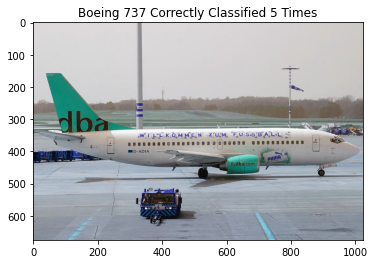

In [ ]:
pic = cv2.imread(correct_df.iloc[49].path)
plt.title('Boeing 737 Correctly Classified 5 Times')
plt.imshow(pic)

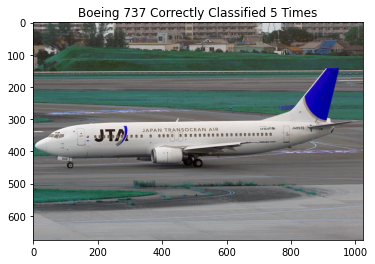

In [ ]:
pic = cv2.imread(correct_df.iloc[70].path)
plt.title('Boeing 737 Correctly Classified 5 Times')
plt.imshow(pic)

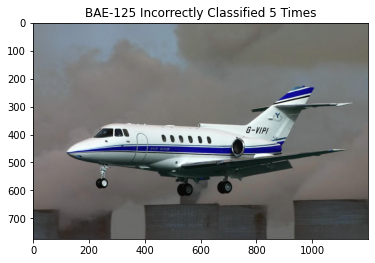

In [ ]:
pic = cv2.imread(incorrect_df.iloc[555].path)
plt.title('BAE-125 Incorrectly Classified 5 Times')
plt.imshow(pic)

In [ ]:
incorrect_df.iloc[555]

image                                            0697871.jpg
dataset                                           validation
label                                                BAE-125
path       gdrive/MyDrive/top_gun_dl/repo/data/images/cro...
Name: 1323, dtype: object

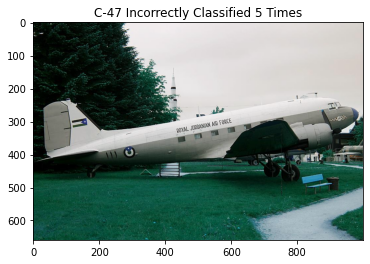

In [ ]:
pic = cv2.imread(incorrect_df.iloc[667].path)
plt.title('C-47 Incorrectly Classified 5 Times')
plt.imshow(pic)

In [ ]:
incorrect_df.iloc[667]

image                                            0618973.jpg
dataset                                           validation
label                                                   C-47
path       gdrive/MyDrive/top_gun_dl/repo/data/images/cro...
Name: 1435, dtype: object